In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
!pip install torchvision pillow
!pip install mlflow

In [8]:
# Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.metrics import classification_report, confusion_matrix

# Constants
# Replace with the actual path to your dataset
data_dir = 'chest_xray/chest_xray/'
labels = ['PNEUMONIA', 'NORMAL']
img_size = 64
num_epochs = 10
batch_size = 32

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cpu


In [9]:
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_arr is not None:
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))
                    data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

# Load the data for train, val, and test splits
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

train_data = get_data(train_dir)
val_data = get_data(val_dir)
test_data = get_data(test_dir)

print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}")

Training data size: 5216
Validation data size: 16
Test data size: 624


In [10]:
class ChestXrayDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, label = self.data[idx]
        image = np.array(image, dtype=np.uint8)
        
        if image.ndim == 2:
            image = np.expand_dims(image, axis=-1)
        
        if self.transform:
            image = self.transform(image)
        return image, label

# REFINED TRANSFORMS to combat overfitting
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(30, fill=0),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Added ColorJitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create Dataset and DataLoader instances
train_dataset = ChestXrayDataset(train_data, transform=train_transforms)
val_dataset = ChestXrayDataset(val_data, transform=val_transforms)
test_dataset = ChestXrayDataset(test_data, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [11]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
        )
        
        # Calculate the size of the flattened layer
        # Assumes img_size=64, with 5 pooling layers of kernel size 2
        # Final dimension will be 64 / (2^5) = 2. But your model is 4*4
        # Let's use a dynamic way
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 2 * 2, 128), # Adjusted based on typical architecture
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Calculate class weights for imbalanced data
pneumonia_count = sum(1 for _, label in train_data if label == 0)
normal_count = sum(1 for _, label in train_data if label == 1)
total_samples = len(train_data)

pos_weight = torch.tensor([normal_count / pneumonia_count]).to(device)
print(f"Pneumonia count: {pneumonia_count}, Normal count: {normal_count}")
print(f"Positive weight for loss function: {pos_weight.item():.2f}")

model = CNNModel().to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []

print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device, dtype=torch.float), labels.to(device, dtype=torch.float).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    
    # Validation
    model.eval()
    val_correct, val_total, val_loss_sum = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device, dtype=torch.float), labels.to(device, dtype=torch.float).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_sum += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_acc = 100 * val_correct / val_total
    val_loss = val_loss_sum / len(val_loader)
    
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

print("Training complete.")

Pneumonia count: 3875, Normal count: 1341
Positive weight for loss function: 0.35
Starting training...
Epoch [1/10], Train Loss: 0.1457, Train Acc: 86.12%, Val Loss: 0.2797, Val Acc: 68.75%
Epoch [2/10], Train Loss: 0.1018, Train Acc: 91.58%, Val Loss: 0.3649, Val Acc: 62.50%
Epoch [3/10], Train Loss: 0.0913, Train Acc: 92.14%, Val Loss: 0.4573, Val Acc: 75.00%
Epoch [4/10], Train Loss: 0.0774, Train Acc: 93.88%, Val Loss: 0.4142, Val Acc: 56.25%
Epoch [5/10], Train Loss: 0.0739, Train Acc: 94.38%, Val Loss: 0.3712, Val Acc: 56.25%
Epoch [6/10], Train Loss: 0.0677, Train Acc: 94.65%, Val Loss: 0.3265, Val Acc: 68.75%
Epoch [7/10], Train Loss: 0.0714, Train Acc: 94.56%, Val Loss: 0.2783, Val Acc: 68.75%
Epoch [8/10], Train Loss: 0.0639, Train Acc: 95.38%, Val Loss: 0.3155, Val Acc: 56.25%
Epoch [9/10], Train Loss: 0.0639, Train Acc: 95.09%, Val Loss: 0.2639, Val Acc: 75.00%
Epoch [10/10], Train Loss: 0.0581, Train Acc: 95.48%, Val Loss: 0.5348, Val Acc: 68.75%
Training complete.


In [12]:
# Initial correct definition of labels
class_names = ['PNEUMONIA', 'NORMAL']

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    # Rename the loop variable to avoid overwriting the class_names variable
    for images, batch_labels in test_loader:
        images = images.to(device, dtype=torch.float)
        batch_labels = batch_labels.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float().cpu().numpy()
        y_true.extend(batch_labels.cpu().numpy())
        y_pred.extend(preds)

# Use the correctly named variable for the report
print(classification_report(y_true, y_pred, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

   PNEUMONIA       0.92      0.91      0.92       390
      NORMAL       0.85      0.87      0.86       234

    accuracy                           0.90       624
   macro avg       0.89      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624

Confusion Matrix:
 [[355  35]
 [ 30 204]]


In [13]:
import hiddenlayer as hl

sample_input = torch.randn(1, 1, 224, 224)
hl_graph = hl.build_graph(model, sample_input)
hl_graph.save("cnn_hiddenlayer", format="png")


ModuleNotFoundError: No module named 'hiddenlayer'

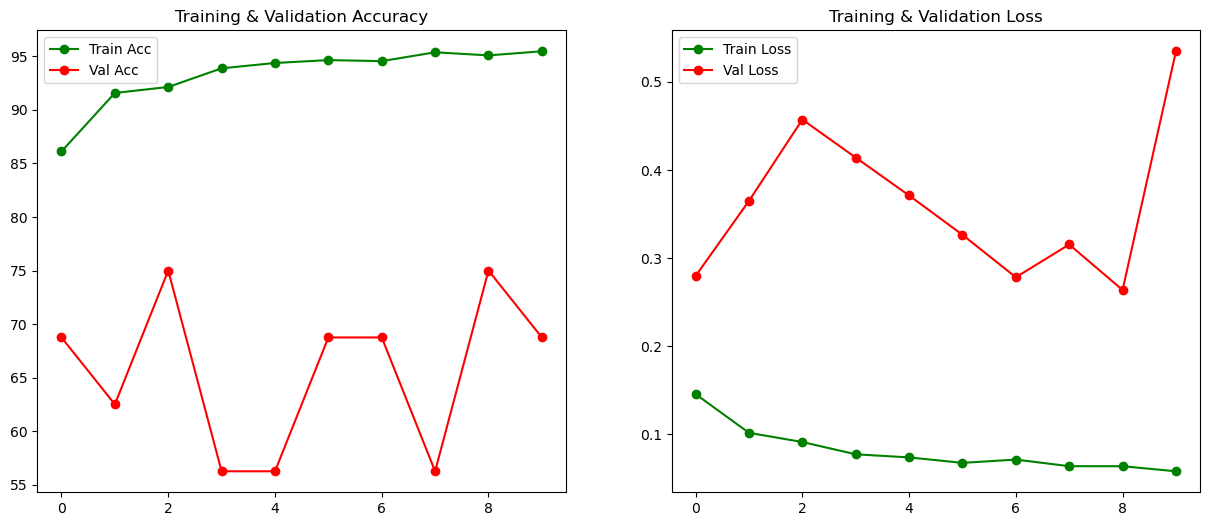

In [14]:
epochs = range(num_epochs)
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(epochs, train_acc_history, 'go-', label='Train Acc')
ax[0].plot(epochs, val_acc_history, 'ro-', label='Val Acc')
ax[0].set_title("Training & Validation Accuracy")
ax[0].legend()

ax[1].plot(epochs, train_loss_history, 'go-', label='Train Loss')
ax[1].plot(epochs, val_loss_history, 'ro-', label='Val Loss')
ax[1].set_title("Training & Validation Loss")
ax[1].legend()

plt.show()


In [ ]:
!pip install --upgrade requests urllib3 chardet


In [15]:
from sklearn.metrics import classification_report

report_dict = classification_report(y_true, y_pred, output_dict=True)

print(report_dict)


{'0': {'precision': 0.922077922077922, 'recall': 0.9102564102564102, 'f1-score': 0.9161290322580645, 'support': 390.0}, '1': {'precision': 0.8535564853556485, 'recall': 0.8717948717948718, 'f1-score': 0.8625792811839323, 'support': 234.0}, 'accuracy': 0.8958333333333334, 'macro avg': {'precision': 0.8878172037167853, 'recall': 0.891025641025641, 'f1-score': 0.8893541567209984, 'support': 624.0}, 'weighted avg': {'precision': 0.8963823833070694, 'recall': 0.8958333333333334, 'f1-score': 0.8960478756052649, 'support': 624.0}}


In [19]:
import mlflow
import mlflow.pytorch
from sklearn.metrics import classification_report

# 1️⃣ Generate predictions and report_dict
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float()  # For binary classification
        y_true.extend(labels.cpu().numpy().flatten())
        y_pred.extend(preds.cpu().numpy().flatten())

report_dict = classification_report(y_true, y_pred, output_dict=True)

# 2️⃣ MLflow setup
mlflow.set_tracking_uri("http://127.0.0.1:5000/")  # Adjust if needed
mlflow.set_experiment("CNN")

params = {"epochs": 10, "batch_size": 32, "optimizer": "Adam"}  # example

# 3️⃣ Log params, metrics, and model
with mlflow.start_run():
    mlflow.log_params(params)

    # Log metrics dynamically
    metrics = {'accuracy': report_dict['accuracy'], 'f1_score_macro': report_dict['macro avg']['f1-score']}
    for key, value in report_dict.items():
        if key not in ['accuracy', 'macro avg', 'weighted avg']:
            metrics[f"recall_class_{key}"] = value['recall']
            metrics[f"precision_class_{key}"] = value['precision']
            metrics[f"f1_class_{key}"] = value['f1-score']

    mlflow.log_metrics(metrics)
    mlflow.pytorch.log_model(model, "CNN_model")

print("MLflow logging complete!")


2025/09/22 19:36:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/22 19:36:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run fortunate-bug-465 at: http://127.0.0.1:5000/#/experiments/973577438642074843/runs/9ee5df4dbb7242579bce6dfbf060ead8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/973577438642074843
MLflow logging complete!
